# Predicting Ahead
This offsets the data by 24 hours, and adds an additional column for the 24 hours ahead time.


In [2]:
from capymoa.regressor import KNNRegressor, AdaptiveRandomForestRegressor
from capymoa.stream._stream import NumpyStream
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint  # Import pprint module

path_to_csv = Path("../power_plant/MHPA-docs-data.csv")
data = pd.read_csv(path_to_csv).fillna(0)  #.to_numpy()


# remove slrmj_tot, recnum, tmstamp from x_features, so they are not used as features

data = data.drop(columns=["RecNum", "TmStamp", "SlrMJ_Tot", "in_bytes_str"])

# The target variable is slrw_avg column, but offset 24 hours (we are predicting in the future)
# column 12 is slrw_avg, so we want to predict column 12, but offset 24 hours. One row is 1 minute, so 24 hours is 1440 rows
# this will decrease the dataset size by 1440 rows
targets = data["SlrW_Avg"].iloc[1440:].to_numpy()
x_features = data[:-1440].to_numpy()




stream = NumpyStream(
    x_features,
    targets,
    target_type="numeric", # "numeric" or "categorical", we are doing regression
    feature_names=["batt_volt", "mean_wind_speed", "mean_wind_direction", "std_wind_dir", "Max_Gust_Min", "Max_Gust_Hr","Rain_mm","Barametric_Avg","Air_Temp_Avg","RH_Avg","SlrW_avg","Dew_Point_Avg"],
)
schema = stream.get_schema()

In [5]:
# Define the models to test
import regressors
from capymoa.regressor import SOKNLBT, SGDRegressor, PassiveAggressiveRegressor, ORTO, ARFFIMTDD, AdaptiveRandomForestRegressor, FIMTDD

models = [
    regressors.GaussianRandomRegressor(schema=schema),
    regressors.LastGuessRegressor(schema=schema),
    PassiveAggressiveRegressor(schema),
    AdaptiveRandomForestRegressor(schema),
    FIMTDD(schema),
]

Running GaussianRandomRegressor
Done in 22.114431665000005 secs
Running LastGuessRegressor


KeyboardInterrupt: 

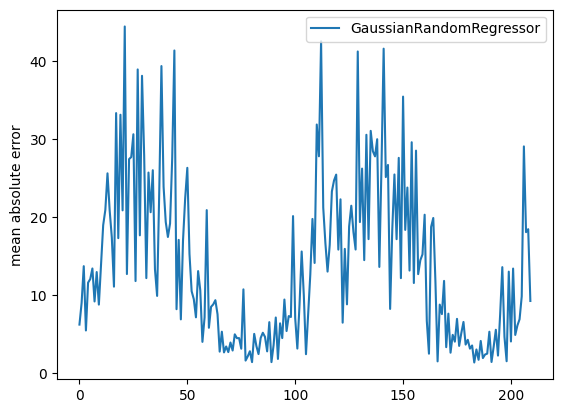

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Run all tests

results = []

for learner in models:
    print(f"Running {learner}")
    result = prequential_evaluation(stream=stream, learner=learner, window_size=5000)
    print(f"Done in {result['cpu_time']} secs")
    sns.lineplot(result['windowed'].metrics_per_window()["mean absolute error"], label=learner.__str__())
    results.append(result)

plt.show()


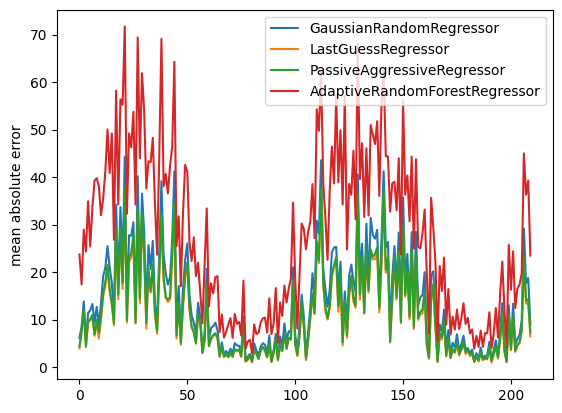

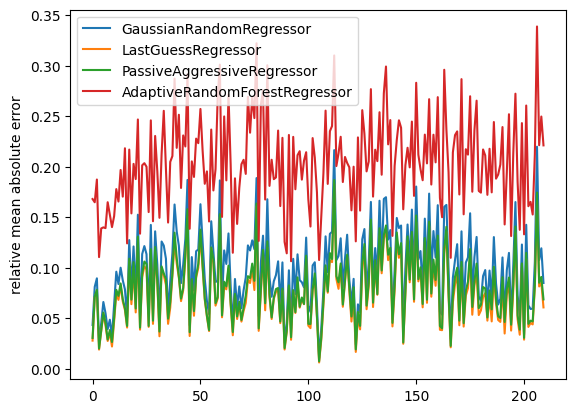

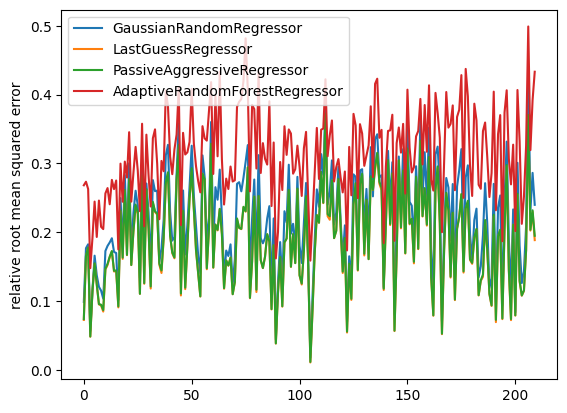

In [ ]:
for learner, result in zip(models, results):
    if learner.__str__() != "FIMTDD":
        sns.lineplot(result['windowed'].metrics_per_window()["mean absolute error"], label=learner.__str__())
plt.show()

for learner, result in zip(models, results):
    if learner.__str__() != "FIMTDD":
        sns.lineplot(result['windowed'].metrics_per_window()["relative mean absolute error"], label=learner.__str__())
plt.show()

for learner, result in zip(models, results):
    if learner.__str__() != "FIMTDD":
        sns.lineplot(result['windowed'].metrics_per_window()["relative root mean squared error"], label=learner.__str__())

plt.show()

In [11]:
#reg = regressors.RandomRegressor(schema=stream.get_schema())
from capymoa.regressor import SOKNLBT, SGDRegressor, PassiveAggressiveRegressor, ORTO, ARFFIMTDD, AdaptiveRandomForestRegressor, FIMTDD

reg = PassiveAggressiveRegressor(schema=stream.get_schema())
res = prequential_evaluation(stream=stream, learner=reg, window_size=5000, store_predictions=True,store_y=True)

res

/home/bd65/miniconda3/lib/python3.12/site-packages/capymoa/evaluation/evaluation.py:268: UserWarning: The learner did not produce a prediction for this instance
  warnings.warn("The learner did not produce a prediction for this instance")


{'learner': 'PassiveAggressiveRegressor',
 'cumulative': <capymoa.evaluation.evaluation.RegressionEvaluator at 0x7462a1bf8a70>,
 'windowed': <capymoa.evaluation.evaluation.RegressionWindowedEvaluator at 0x7462a1bfb650>,
 'wallclock': 621.4767529964447,
 'cpu_time': 618.597165313,
 'max_instances': None,
 'stream': <capymoa.stream._stream.NumpyStream at 0x7462b2b23b30>,
 'predictions': [None,
  232.0268474537797,
  152.21372824826688,
  127.14610795627772,
  148.01653799148497,
  122.36890799679834,
  168.92118373485587,
  158.03050278828152,
  165.72641809040286,
  184.01350508009426,
  255.3830400609918,
  209.7543304240646,
  200.0302337388192,
  169.86375398861418,
  182.26658837164035,
  144.63490237902334,
  124.99443248707908,
  134.40135630357548,
  123.76975023858279,
  111.3322921358697,
  107.9694924129366,
  110.60851461301213,
  112.88957032300115,
  114.77719876130574,
  114.70568870997353,
  114.76797546344494,
  114.75896460608702,
  113.9212191484854,
  111.664388258789

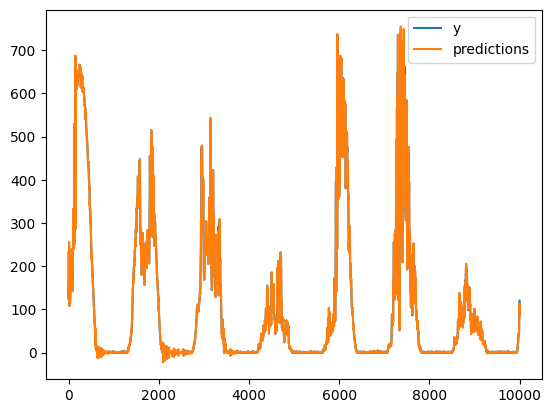

In [14]:
#sns.lineplot(res['predictions'], label="predictions")
#sns.lineplot(result['ground_truth_y'], label="y")
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(range(0,10000),  res['predictions'][:10000], label="predictions")

plt.plot(range(0,10000), res['ground_truth_y'][:10000], label="y")

# show label
plt.legend()

#res.keys()

<Axes: ylabel='mean absolute error'>

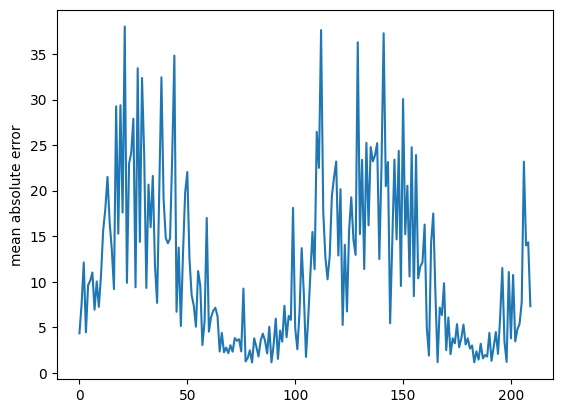

In [15]:

sns.lineplot(res['windowed'].metrics_per_window()["mean absolute error"])